# Implicit feedback recommender system
- https://github.com/benfred/implicit
- https://www.benfrederickson.com/matrix-factorization/
- https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
- https://kojinoshiba.com/recsys-cold-start/

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

# Data Exploration

In [2]:
# Read csv files
df = pd.read_csv('events_example.csv')

In [3]:
# Get df_events and correctly encode the variables
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.astype({'visitorid': object, 'itemid': object, 'transactionid': object})
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [4]:
# Describe dataset
df.describe(include='all', datetime_is_numeric=True)

,timestamp,visitorid,event,itemid,transactionid
count,2756101,2756101.0,2756101,2756101.0,22457.0
unique,NaN,1407580.0,3,235061.0,17672.0
top,NaN,1150086.0,view,187946.0,7063.0
freq,NaN,7757.0,2664312,3412.0,31.0
mean,2015-07-09 06:48:08.348103680,NaN,NaN,NaN,NaN
min,2015-05-03 03:00:04.384000,NaN,NaN,NaN,NaN
25%,2015-06-05 04:23:14.792000,NaN,NaN,NaN,NaN
50%,2015-07-09 14:43:33.599000064,NaN,NaN,NaN,NaN
75%,2015-08-10 16:45:05.168000,NaN,NaN,NaN,NaN
max,2015-09-18 02:59:47.788000,NaN,NaN,NaN,NaN


In [5]:
# Value counts of event
df['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [6]:
# Missing values
df.isna().sum()  # transactionid is only present when the event is transaction

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

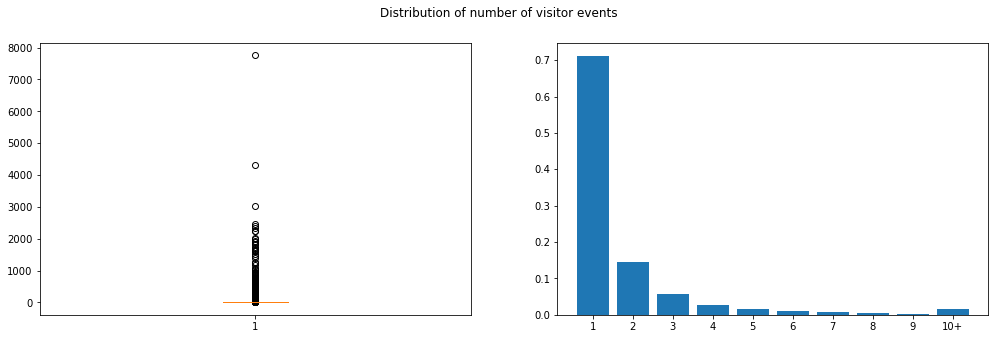

28.85% of visitors have more than 1 event!


In [7]:
# Distribution of number of visitor events
data1 = df['visitorid'].value_counts()  # count of events per visitorid
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per visitorid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of visitor events")

plt.show()
print("{0:.2f}% of visitors have more than 1 event!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

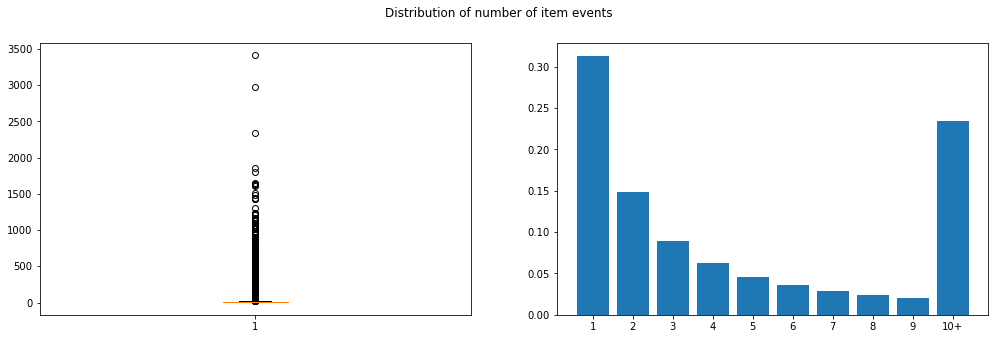

68.69% of items have more than 1 event!


In [8]:
# Distribution of number of item events
data1 = df['itemid'].value_counts()  # count of events per visitorid
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per visitorid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of item events")

plt.show()
print("{0:.2f}% of items have more than 1 event!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

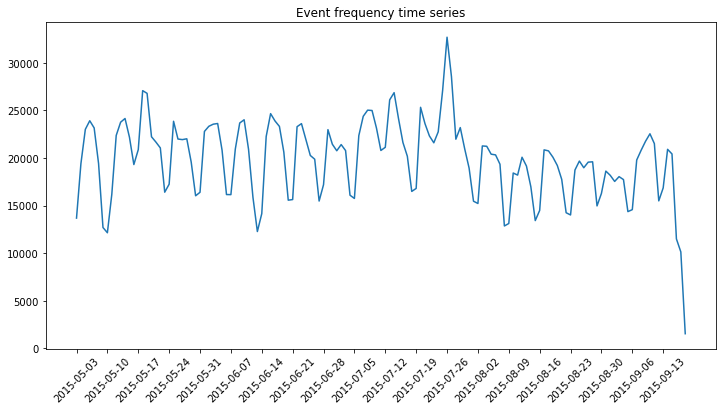

In [9]:
# Visualize number of events per day
data = pd.DatetimeIndex(df['timestamp']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

In [10]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 138 days, corresponding to 19 weeks.


# Reduce Sparsity

> **While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense.**

- To reduce sparsity we can exclude users or/and items without significant event history ([cold-start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)))
- We limited our dataset to users and items with at least 5 event occurrences.

In [11]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['visitorid'].nunique()
    n_items = df['itemid'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('visitorid').size()  # user id frequencies
        df = df[~df['visitorid'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('itemid').size()  # item id frequencies
        df = df[~df['itemid'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('visitorid').size().min() >= uid_min)
        assert(df.groupby('itemid').size().min() >= iid_min)
    
    n_users = df['visitorid'].nunique()
    n_items = df['itemid'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [12]:
# get limited dataset
df_limited = threshold_ratings(df, 7, 7)

Raw dataset info 
-----------------
Number of users: 1407580
Number of items: 235061
Sparsity: 0.001%
Limited dataset info 
-----------------
Number of iterations until convergence: 12
Number of users: 31735
Number of items: 22576
Sparsity: 0.076%


# Train-test split
We want to split the train and test events such that:
- all test events occur after all train events

In [13]:
# Train-test split
start_train = df_limited['timestamp'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['timestamp'] > start_train) & (df_limited['timestamp'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['timestamp'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.82


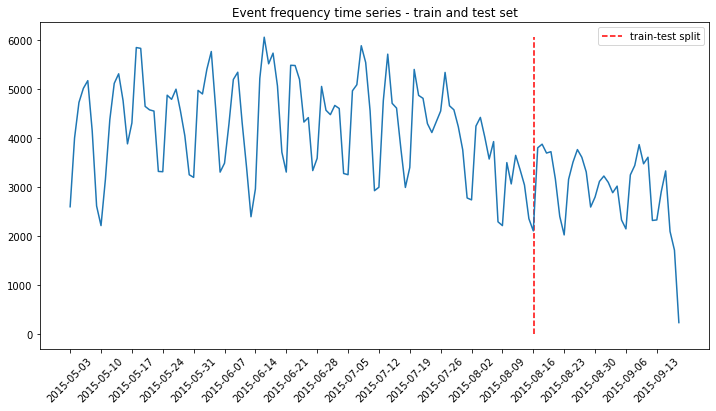

In [14]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['timestamp']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

<img src="./images/MaskTrain.png" alt="MaskTrain" style="width: 600px;"/>

In [15]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['visitorid'].astype('category')
item_cat = df_limited['itemid'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (22576, 31735) and test set shape: (22576, 31735)
train set percentage of zeros: 99.96960022408284 and test set percentage of zeros: 99.99313154526371


In [16]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [17]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['visitorid'] == user_id) & (df_limited['itemid'] == item_id) & (df_limited['train_split'] == 1)]

,timestamp,visitorid,event,itemid,transactionid,train_split
6929,2015-06-01 15:18:39.559,388556,view,306289,NaN,1
8599,2015-06-01 23:53:01.983,388556,view,306289,NaN,1
8625,2015-06-01 23:44:07.473,388556,view,306289,NaN,1
11133,2015-06-01 15:18:28.989,388556,view,306289,NaN,1
15572,2015-06-01 23:43:57.238,388556,view,306289,NaN,1
...,...,...,...,...,...,...
2144682,2015-07-05 16:15:20.653,388556,view,306289,NaN,1
2149725,2015-07-05 23:50:53.434,388556,view,306289,NaN,1
2159258,2015-07-06 20:32:44.467,388556,view,306289,NaN,1
2170254,2015-07-06 20:28:15.581,388556,view,306289,NaN,1


# Fit the ALS model

<img src="./images/Tables.png" alt="Tables" style="width: 1000px;"/>


<img src="./images/ALS_Image_Test.png" alt="MaskTrain" style="width: 600px;"/>


Each (user, item) pair is represented initially through a Ranking matrix, which is used to create a Preference matrix and a Confidence matrix. These give information on whether a user likes an item or not and how confident we are of of the preference values, respectively.

The classical latent factor model is induced by the SVD of the user-item observations matrix that associates each user with a user-factors vector and each item with an item-factors vector. The recommendation score between a user and a item is obtained by taking the inner product between the corresponding user-factors and the item-factors vector. The objective function is based on a least-squares with L2 regularization and this function is minimized using SGD.

The ALS model for implicit feedback data also finds the user-factors and the item-factors vectors by factoring the Preference Matrix. The objective function has two main differences: it accounts for the varying confidence levels (using the Confidence matrix) and it accounts for all possible user/item pairs (note the summation indexes) rather than only those corresponding to observed data (if a user did not consumed a certain item it might be because the user dislikes the item or just because the user did not know about the item). The ALS model objective function is provided below:

<img src="./images/equation.png" alt="MaskTrain" style="width: 600px;"/>

The huge number of terms (m users x n items) in the objective function prevents most direct optimization techniques such as SGD. An alternating-least-squares (ALS) optimization process (ALS) is used instead.



In [18]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

  0%|          | 0/30 [00:00<?, ?it/s]

# ALS model methods

In [19]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[(181142, 0.9557572),
 (15564, 0.29176143),
 (143180, 0.2770565),
 (3379, 0.25408393),
 (418619, 0.25371945),
 (182184, 0.2431688),
 (29447, 0.24041873),
 (364251, 0.23926802),
 (13101, 0.23266086),
 (178985, 0.22985822)]

In [20]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[(248676, 1.0),
 (156271, 0.9159243),
 (322577, 0.9127971),
 (404264, 0.90587825),
 (317557, 0.8971296),
 (80921, 0.88508785),
 (116706, 0.8847025),
 (29519, 0.8847006),
 (289008, 0.88436794),
 (245481, 0.88309985)]

In [21]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  -0.03952744407948464
The top N (itemid, score) contributions for this user/item pair are:
 [(181142, -0.03952744407948464)]


# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. For new users in production, there is a `recalculate_user` method which can be used for generating recommendations without recalculating the whole model. Also, the `recommend(recalculate_user=True)` method allows the model to recommend for new users on the fly ([github issue](https://github.com/benfred/implicit/issues/152)).

In [22]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [23]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [24]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

  0%|          | 0/31735 [00:00<?, ?it/s]

  0%|          | 0/31735 [00:00<?, ?it/s]

,pop_model,als_model
precision,0.011877,0.015944
map,0.005428,0.007908
ndcg,0.009695,0.013737
auc,0.504633,0.508189
